# Colab Notebook 2

Significant testing of hypothesis 3 and 4 conducted in the later portions of this notebook,  as well as a function that calculates average cost of ticket by borough.

In [ ]:
# np-pd-mpl
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

# Built-in
import warnings
warnings.filterwarnings('ignore')
import os
import sys
import time
import copy
import random
import pickle
from typing import List, Tuple, Dict, Any
import logging
import collections
logging.getLogger('lightning').setLevel(0)

In [ ]:
df.dropna(axis=1).shape, df.shape

((9745393, 17), (9745393, 43))

In [ ]:
def remove_null_features(pct=0.1):
    chopping_block_cols = df.isnull().mean() >= 0.1
    chopping_block_cols.index[0]
    chopping_block: list = [chopping_block_cols.index[idx] 
        for idx, b in enumerate(chopping_block_cols) if b]
    return df.drop(axis=1, columns=chopping_block)

df = remove_null_features()

In [ ]:
# Converts issue dates to datetimes and adds an extra dayofweek column
def clean_dates(df):
    Issue=df['Issue Date']
    Issue = Issue.astype(str)
    stripped = [i.split() for i in Issue]
    dates = [s[0].replace('/','-' ) for s in stripped]
    dates = pd.to_datetime(dates)
    df.insert(0, 'Date', dates, allow_duplicates=True)
    df.insert(1, 'DayOfWeek', dates.dayofweek, allow_duplicates=True)

In [ ]:
###### Cleaning 
df = remove_null_features()
clean_dates(df)
# Drop some of the other stuff. 
df = df.drop(['Issue Date', 'Summons Number', 'Plate ID'], axis=1)
df.head()

,Date,DayOfWeek,Registration State,Plate Type,Violation Code,Vehicle Body Type,Vehicle Make,Issuing Agency,Street Code1,Street Code2,...,Issuer Code,Violation Time,Violation County,Street Name,Date First Observed,Law Section,Sub Division,Vehicle Color,Vehicle Year,Feet From Curb
0,2020-07-02,3,NY,PAS,20,SUBN,NISSA,P,62200,33525,...,955757,1259P,Q,SHORE FRONT PKWY,0,408,D,GRAY,2018,0
1,2020-06-27,5,NY,PAS,20,P-U,DODGE,P,60790,34190,...,952795,0940A,Q,ROCKAWAY BEACH BLVD,0,408,D,BLU,2018,0
2,2020-06-27,5,NY,PAS,20,SUBN,KIA,P,60790,40404,...,952795,0940A,Q,ROCKAWAY BEACH BLVD,0,408,D,BLU,2020,0
3,2020-06-27,5,NY,PAS,20,SUBN,JEEP,P,60790,34190,...,952795,0940A,Q,ROCKAWAY BEACH BLVD,0,408,D,BLK,2009,0
4,2020-06-27,5,NY,PAS,20,SUBN,SUBAR,P,60790,34190,...,952795,0940A,Q,ROCKAWAY BEACH BLVD,0,408,D,BLK,2015,0


In [ ]:
for column in df: 
    print(column, len(df[column].unique()))

Date 1041
DayOfWeek 7
Registration State 68
Plate Type 83
Violation Code 99
Vehicle Body Type 1119
Vehicle Make 2918
Issuing Agency 18
Street Code1 6294
Street Code2 6613
Street Code3 6518
Vehicle Expiration Date 3532
Violation Precinct 152
Issuer Precinct 421
Issuer Code 21464
Violation Time 1610
Violation County 13
Street Name 39788
Date First Observed 327
Law Section 8
Sub Division 136
Vehicle Color 1502
Vehicle Year 97
Feet From Curb 16


Number of valid dates in specified range:  408
Number of valid dates with value counts above threshold:  277


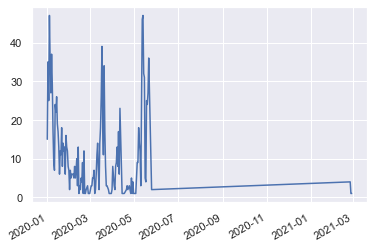

In [ ]:
# Drop all dates that don't occur more than some given number of times?
# Perhaps same result as dropping all dates that don't fall between desired range. 

def date_verification(df, threshold):
    start_date, end_date = '2020-01-01', '2021-03-01'
    
    mask = (df['Date'] >= start_date) & (df['Date'] <= end_date)
    masked_dates = df.loc[mask].Date.unique()
    print('Number of valid dates in specified range: ', len(masked_dates))
    threshold_dates = df[df.groupby('Date')['Date'].transform('size') > threshold].Date.unique()
    print('Number of valid dates with value counts above threshold: ', len(threshold_dates))
    
    diff_dates =  set(masked_dates) - set(threshold_dates)
    diff_dates = np.datetime_as_string(list(diff_dates))
    return df[df.Date.isin(diff_dates)].Date.value_counts()

# Lazy plot of valid dates with unusually low value counts 
date_verification(df, 50).plot()

In [ ]:
df = df[df.groupby('Date')['Date'].transform('size') > 50]
df.head()

,Date,DayOfWeek,Registration State,Plate Type,Violation Code,Vehicle Body Type,Vehicle Make,Issuing Agency,Street Code1,Street Code2,...,Issuer Code,Violation Time,Violation County,Street Name,Date First Observed,Law Section,Sub Division,Vehicle Color,Vehicle Year,Feet From Curb
0,2020-07-02,3,NY,PAS,20,SUBN,NISSA,P,62200,33525,...,955757,1259P,Q,SHORE FRONT PKWY,0,408,D,GRAY,2018,0
1,2020-06-27,5,NY,PAS,20,P-U,DODGE,P,60790,34190,...,952795,0940A,Q,ROCKAWAY BEACH BLVD,0,408,D,BLU,2018,0
2,2020-06-27,5,NY,PAS,20,SUBN,KIA,P,60790,40404,...,952795,0940A,Q,ROCKAWAY BEACH BLVD,0,408,D,BLU,2020,0
3,2020-06-27,5,NY,PAS,20,SUBN,JEEP,P,60790,34190,...,952795,0940A,Q,ROCKAWAY BEACH BLVD,0,408,D,BLK,2009,0
4,2020-06-27,5,NY,PAS,20,SUBN,SUBAR,P,60790,34190,...,952795,0940A,Q,ROCKAWAY BEACH BLVD,0,408,D,BLK,2015,0


In [ ]:
def lazy_verification(df, threshold):
    for col in df: 
        threshold_df = df[df.groupby(col)[col].transform('size') > threshold]
        print(col, len(threshold_df[col].unique()), len(df[col].unique()))
lazy_verification(df, 50)

Date 277 277
DayOfWeek 7 7
Registration State 60 61
Plate Type 48 81
Violation Code 78 98
Vehicle Body Type 109 126
Vehicle Make 164 174
Issuing Agency 12 16
Street Code1 3478 3894
Street Code2 3534 5880
Street Code3 3505 5801
Vehicle Expiration Date 1364 3190
Violation Precinct 78 139
Issuer Precinct 106 314
Issuer Code 2713 15081
Violation Time 1500 1557
Violation County 9 11
Street Name 6494 6587
Date First Observed 194 277
Law Section 6 8
Sub Division 119 136
Vehicle Color 203 203
Vehicle Year 58 58
Feet From Curb 13 16


In [ ]:
def lazy_cut(df, threshold, chopping_block):
    for col in chopping_block:
        df = df[df.groupby(col)[col].transform('size') > threshold]
    return df

In [ ]:
interest = ['Registration State', 'Vehicle Body Type', 'Vehicle Make', 'Street Name', 'Vehicle Color', 'Vehicle Year']
df=lazy_cut(df, 50, interest)

In [ ]:
dics = []

dic = {}
for col in interest: 
    dic[col] = df[col].value_counts()
dics.append(dic)

for i in range(7):
    dic = {}
    numrows = len(df.loc[df.DayOfWeek == i])
    for col in interest: 
        dic[col] = df.loc[df.DayOfWeek == i][col].value_counts()/numrows
    dics.append(dic)

<Figure size 432x288 with 0 Axes>

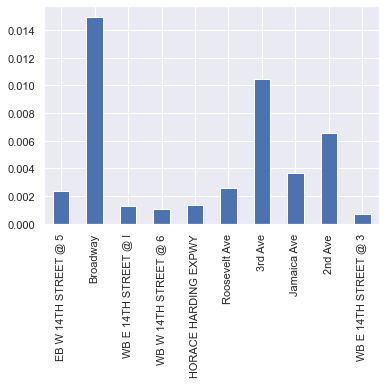

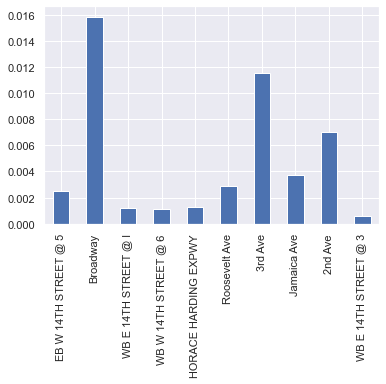

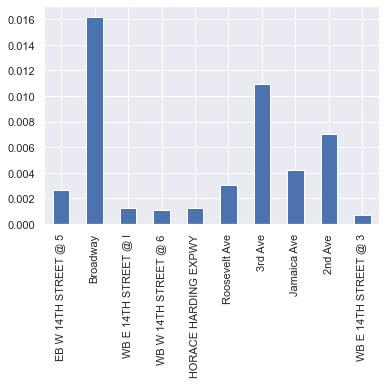

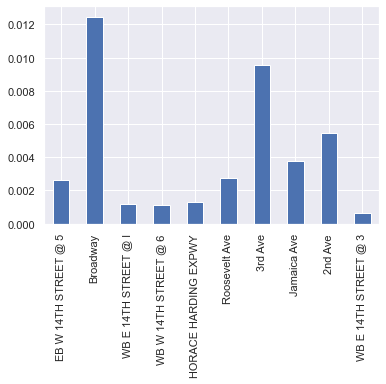

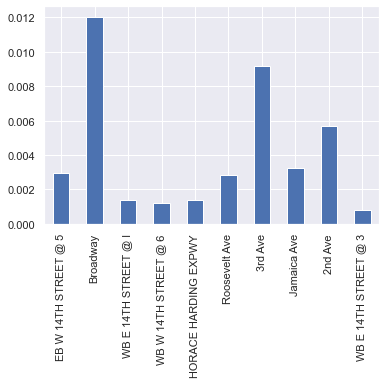

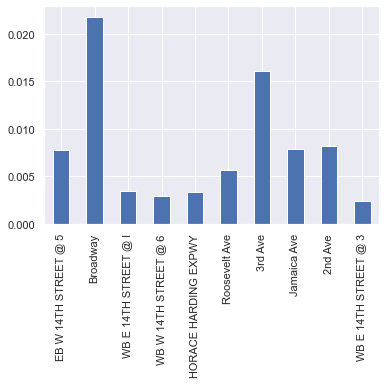

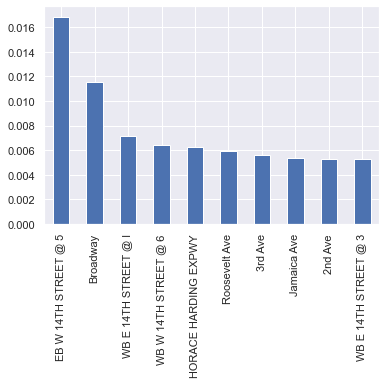

In [ ]:
plt.figure()
for i in range(1,8):
    plt.figure()
    idx = ['EB W 14TH STREET @ 5', 'Broadway', 'WB E 14TH STREET @ I',
       'WB W 14TH STREET @ 6', 'HORACE HARDING EXPWY', 'Roosevelt Ave',
       '3rd Ave', 'Jamaica Ave', '2nd Ave', 'WB E 14TH STREET @ 3']
    dics[i]['Street Name'][idx].plot(kind = 'bar')

plt.show()

Broadway                132830
3rd Ave                  95565
5th Ave                  62326
2nd Ave                  58052
Madison Ave              52597
Lexington Ave            51085
1st Ave                  42790
WB CONDUIT BLVD @ LI     41750
Queens Blvd              39225
6th Ave                  37171

In [ ]:
# all strings to upper case. lazy binning. 
def all_to_upper(df):
    upper_cols = df.select_dtypes(include=['object']).columns
    for col in upper_cols:
        df[col] = df[col].str.upper()
    return df

# Moves all states other than NY and NJ into an out-of-state bucket. 
def bucket_states(df):
    df.loc[~df['Registration State'].isin(['NY', 'NJ']), 'Registration State'] = 'OOS'
    
df = all_to_upper(df)
bucket_states(df)

In [ ]:
timestamp = []
for time in mini2017['Violation Time']:
    if len(str(time)) == 5:
        time = time[:2] + ':' + time[2:]
        timestamp.append(pd.to_datetime(time, errors='coerce'))
    else:
        timestamp.append(pd.NaT)
    

mini2017 = mini2017.assign(Violation_Time2 = timestamp)
mini2017.drop(['Violation Time'], axis = 1, inplace = True)
mini2017.rename(index=str, columns={"Violation_Time2": "Violation Time"}, inplace = True)

hours = [lambda x: x.hour, mini2017['Violation Time']]

# Getting the histogram
mini2017.set_index('Violation Time', drop=False, inplace=True)
plt.figure(figsize=(16,8))
mini2017['Violation Time'].groupby(pd.TimeGrouper(freq='60Min')).count().plot(kind='bar');
plt.tick_params(labelbottom='on')
plt.ylabel('No. of cars', fontsize=16);
plt.xlabel('Day Time', fontsize=16);
plt.title('Parking ticket given at different time of the day', fontsize=16);

In [ ]:
# Converts issue dates to datetimes and adds an extra dayofweek column
def clean_dates(df):
    Issue=df['Issue Date']
    Issue = Issue.astype(str)
    stripped = [i.split() for i in Issue]
    dates = [s[0].replace('/','-' ) for s in stripped]
    dates = pd.to_datetime(dates)
    df.insert(0, 'Date', dates, allow_duplicates=True)
    df.insert(1, 'DayOfWeek', dates.dayofweek, allow_duplicates=True)

In [ ]:
def convert_times(df):
    timestamp = []
    for time in df['Violation Time']:
        if len(str(time)) == 5:
            time = time[:2] + ':' + time[2:]
            timestamp.append(pd.to_datetime(time, errors='coerce'))
        else: 
            timestamp.append(pd.NaT)
    df['Violation Time'] = [int(str(i.hour) + str(i.minute)) for i in timestamp]
    return df
df = convert_times(df)

In [ ]:
import datetime

def get_time_of_day(df) -> np.ndarray:
    """Args: df (pd.DataFrame): The dataset.
    Returns: time_of_day (np.ndarray): Time of day in minutes 
        for each valid time."""
    hours, minutes = [], []
    ctr = 0 
    for idx, t in enumerate(df['Violation Time']):#.dropna(inplace=False)):
        ctr +=1
        assert isinstance(t, (str, float))
        if isinstance(t, str) and len(t) == 5:
            try:
                hour, minute, ampm = int(t[:2]), int(t[2:-1]), t[-1]
            except: # Invalid time 
                hour, minute, apm = -1, 0, 'A'#continue
        elif isinstance(t, str) and len(t) == 4:
            try:
                hour, minute = int(t[:2]), int(t[2:])
            except:
                hour, minute, apm = -1, 0, 'A'#continue
        else:
            hour, minute, apm = -1, 0, 'A'#continue
            #print(t, 'it me', 'yikes')

        # Translate to military time. 
        if hour == 12 and ampm == 'A':
            hour = 0
        elif hour < 12 and ampm == 'P':
            hour = hour + 12
        elif (hour < 12 and ampm == 'A') or (hour == 12 and ampm == 'P'):
            pass # Valid date, no processing needed
        elif (hour > 12 and hour < 24 and minute < 60): 
            pass # If the officer forgot to write AM/PM
        else:
            hour, minute = -1, 0
        
        hours.append(hour)
        minutes.append(minute)

    hours = np.array(hours, dtype=int)
    minutes = np.array(minutes, dtype=int)
    time_of_day = hours * 100 + 100*minutes/60 
    print(ctr)
    return time_of_day

time_of_day = get_time_of_day(df = df)

8999751


In [ ]:
time_of_day = [i if i >= 0 else np.NaN for i in time_of_day]
time_of_day2 = [x for x in time_of_day2 if x is not np.NaN]
print(len(time_of_day2), len(time_of_day))

9004809 8999751


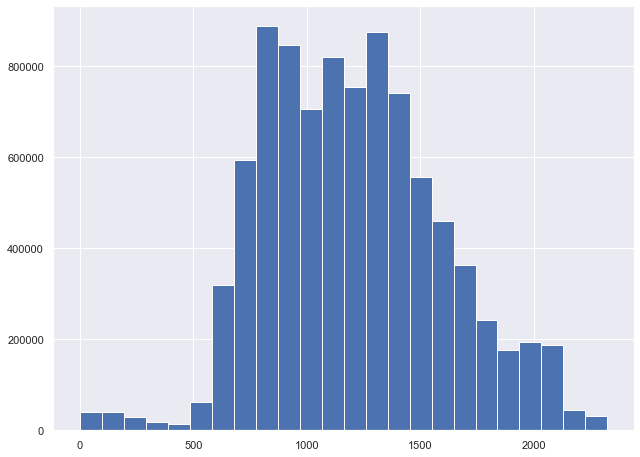

In [ ]:
def plot_time_of_day(tod: np.ndarray, scale = 1.3):
    """Args: tod (np.ndarray): Time of day in minutes."""
    
    figsize = np.array([8, 6]) * scale
    fig, ax = plt.subplots(figsize=figsize)
    # ax.hist(tod)

    #hours = [(t / 100) for t in tod]
    counts, bins = np.histogram(tod, bins=24)
    
    #ax.plot(bins[:-1], counts, weights=counts)
    ax.hist(bins[:-1], bins, weights=counts)
    #plt.setp(ax.get_xticklabels(), rotation=45)
    plt.show()
    #hours_in_day = [f"{h}:00" for h in np.arange(24)]

    #print(hours_in_day)
    #ax.set_xticks(np.arange(24))
    #ax.set_xticklabels(hours_in_day)
    #print(ax.get_xticks(), ax.get_xticklabels())

plot_time_of_day(tod = time_of_day2)

[ 109621  412645 2328930 3155680 2121563  614002  262416       0       0
       0       1       0       1       2       0       2       0       0
       0       0       0       1       1       2] 
 [-101.          269.33333333  639.66666667 1010.         1380.33333333
 1750.66666667 2121.         2491.33333333 2861.66666667 3232.
 3602.33333333 3972.66666667 4343.         4713.33333333 5083.66666667
 5454.         5824.33333333 6194.66666667 6565.         6935.33333333
 7305.66666667 7676.         8046.33333333 8416.66666667 8787.        ] 

[24, 25]


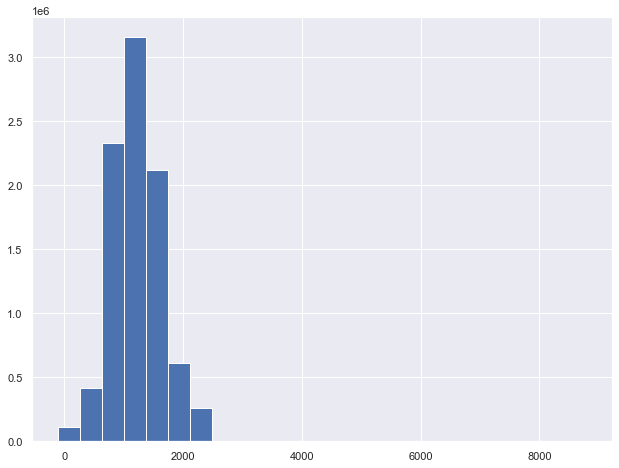

In [ ]:
def plot_time_of_day(tod: np.ndarray, scale = 1.3):
    """Args: tod (np.ndarray): Time of day in minutes."""
    figsize = np.array([8, 6]) * scale
    fig, ax = plt.subplots(figsize=figsize)
    # ax.hist(tod)

    # hours = (tod / 60).round()
    # counts, bins = np.histogram(hours, bins=24)
    # ax.hist(bins[:-1], bins, weights=counts)
    counts, bins = np.histogram(tod, bins=24)
    ax.hist(bins[:-1], bins, weights=counts)
    print(counts, '\n', bins, '\n')
    print([len(x) for x in [counts, bins]])
    # ax.hist(tod, bins=24)

    hours_in_day = [f"{h}:00" for h in np.arange(24)]

    # plt.xticks(np.arange(24), hours_in_day)
    # plt.setp(ax.get_xticklabels(), rotation=45)
    # print(hours_in_day)
    # ax.set_xticks(np.arange(24))
    # ax.set_xticklabels(hours_in_day)
    # print(ax.get_xticks(), ax.get_xticklabels())

    # print(len(counts), len(bins))
    plt.show()

plot_time_of_day(tod = time_of_day)

In [ ]:
df['Violation County'].replace({
    'NY':'Manhattan', 'K':'Brooklyn', 'Q':'Queens', 'BX': 'Bronx', 
    'QN':'Queens', 'BK':'Brooklyn', 'MN': 'Manhattan', 'ST':'Staten Island', 'R':'Staten Island'}, inplace=True)
df = df[df['Violation County'] != 'F']
df.dropna(subset = ['Violation County'], inplace = True)
df['DayOfWeek'].replace({0:'1Mon', 1: '2Tue', 2: '3Wed', 3: '4Thu', 4: '5Fri', 5: '6Sat', 6: '7Sun'}, inplace=True)

In [ ]:
import scipy
Row1 = 'Violation County'
Col1 = 'Registration State'

teststuff = [('Violation County', 'Registration State'), ('Registration State', 'Violation County'), ('DayOfWeek', 'Registration State')]
for (Row1, Col1) in teststuff:
    print('\n{0:<20}'.format(Col1), sorted(df[Col1].unique()))
    stats_test = []
    for value in sorted(df[Row1].unique()):
        if value is not np.nan:
            stats_test.append(df[df[Row1] == value][Col1].value_counts().sort_index().values)
            tempsum = sum(stats_test[-1])
            print('{0:<20}'.format(value), np.round(stats_test[-1]/tempsum,2), 'total:', tempsum)
    stats_test = np.asarray(stats_test)
    statistic, pvalue , _, _ = scipy.stats.chi2_contingency(stats_test.T)
    print('Statistic:', statistic, '\np-value:', pvalue)


Registration State   ['NJ', 'NY', 'OOS']
Bronx                [0.09 0.76 0.15] total: 1192655
Brooklyn             [0.06 0.81 0.14] total: 2389363
Manhattan            [0.14 0.71 0.15] total: 2825740
Queens               [0.04 0.86 0.1 ] total: 2303273
Staten Island        [0.03 0.93 0.04] total: 279695
Statistic: 270746.54705921124 
p-value: 0.0

Violation County     ['Bronx', 'Brooklyn', 'Manhattan', 'Queens', 'Staten Island']
NJ                   [0.14 0.19 0.52 0.13 0.01] total: 738953
NY                   [0.13 0.27 0.28 0.28 0.04] total: 7068182
OOS                  [0.15 0.27 0.37 0.2  0.01] total: 1183591
Statistic: 270746.5470592113 
p-value: 0.0

Registration State   ['NJ', 'NY', 'OOS']
1Mon                 [0.08 0.8  0.13] total: 1473328
2Tue                 [0.08 0.8  0.12] total: 1686835
3Wed                 [0.08 0.8  0.12] total: 1653245
4Thu                 [0.08 0.79 0.13] total: 1672640
5Fri                 [0.08 0.79 0.13] total: 1618488
6Sat                 [0.11 0

In [ ]:
def violations(violation_codes, county):
    print('{0:<15}'.format('Violation Codes'), violation_codes, 'in', county)
    counts = []
    for state in sorted(df['Registration State'].unique()):
        counts.append(df[(df['Violation County'] == county) & (df['Registration State'] == state)]['Violation Code']
                      .value_counts()[violation_codes].values)
        print('{0:<15}'.format(state), np.round(counts[-1]/sum(counts[-1]),2))
    #print(counts)
    
violation_codes = [36, 21, 38, 14, 20, 40]
violations(violation_codes, 'Queens')

Violation Codes [36, 21, 38, 14, 20, 40] in Queens
NJ              [0.09 0.26 0.26 0.12 0.12 0.15]
NY              [0.55 0.15 0.15 0.05 0.05 0.05]
OOS             [0.2  0.25 0.2  0.11 0.11 0.14]


In [ ]:
def get_avg_costs():
    # Dictionary of tickets to price values. 
    ticketdict = {36:50, 21:65, 38:35, 14:115, 20:60, 40:115, 46:115, 71:65, 7:50, 
                  37:35, 5:50, 31:115, 16:95, 19:115, 74:65, 70:65, 16:95,  50:115, 48:115}
    #69:35,47:115,
    print('Total number of violations in each borough:')
    print(df['Violation County'].value_counts(), '\n')
    for county in sorted(df['Violation County'].unique()):
        val_counts = df[df['Violation County'] == county]['Violation Code'].value_counts()[list(ticketdict.keys())]
        totalperticket = list(ticketdict.values()) * val_counts[list(ticketdict.keys())].values
        print('Average cost of ticket in {}: ${}'.format(county, round(sum(totalperticket)/sum(val_counts),2)))

    print('\nMost common tickets make up {:.2f} % of all violations'.format(
        100*sum(df['Violation Code'].value_counts()[list(ticketdict.keys())])/sum(df['Violation Code'].value_counts())))
get_avg_costs()

Total number of violations in each borough:
Manhattan        2825740
Brooklyn         2389363
Queens           2303273
Bronx            1192655
Staten Island     279695
Name: Violation County, dtype: int64 

Average cost of ticket in Bronx: $69.6
Average cost of ticket in Brooklyn: $65.67
Average cost of ticket in Manhattan: $79.68
Average cost of ticket in Queens: $61.29
Average cost of ticket in Staten Island: $54.56

Most common tickets make up 91.39 % of all violations


Borough demographic data: https://furmancenter.org/neighborhoods/view/morningside-heights-hamilton

In [ ]:
#df = pd.read_csv('2021Data.csv')
#df.to_csv('2021Data.csv', index=False)